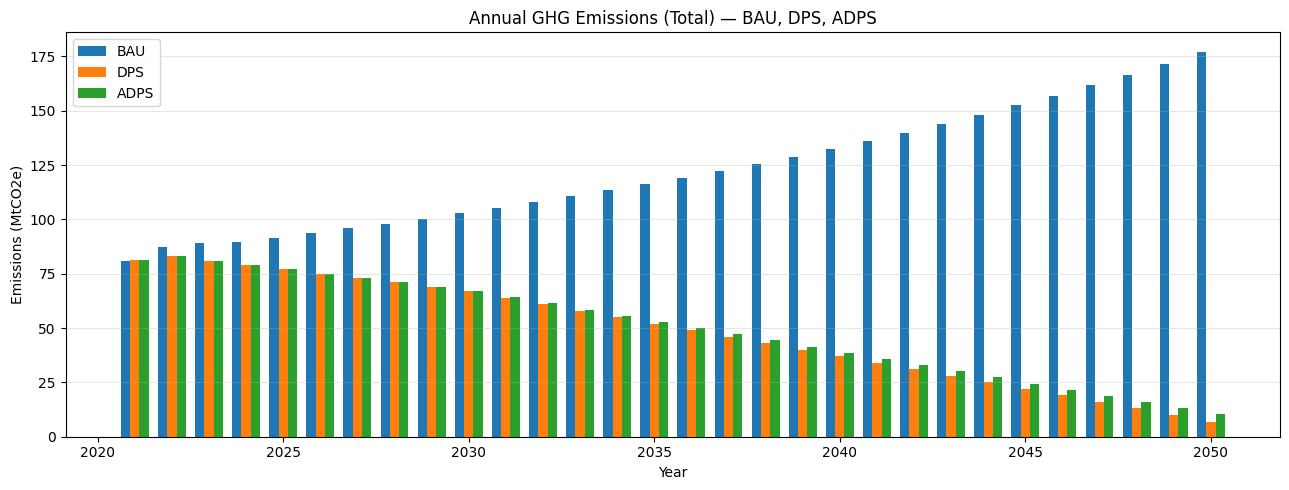

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Data
# -----------------------
years = np.arange(2021, 2051)

DPS = [
81.1843,83,81,79,77,75,73,71,69,67,64,61,58,55,52,49,46,43,40,37,
34,31,28,25,22,19,16,13,10,7
]

ADPS = [
81.1843,83,81,79,77,75,73,71,69,67,64.1625,61.325,58.4875,55.65,52.8125,
49.975,47.1375,44.3,41.4625,38.625,35.7875,32.95,30.1125,27.275,24.4375,
21.6,18.7625,15.925,13.0875,10.25
]

BAU = [
81.0990,87.1302,88.9620,89.6262,91.4175,93.8369,96.0716,98.0487,100.3860,
102.8381,105.3373,107.9335,110.6299,113.3751,116.2745,119.2839,122.4066,
125.6463,128.9043,132.3272,135.9357,139.6768,143.7537,148.0248,152.4415,
157.0085,161.6578,166.5377,171.7494,177.2452
]

# bar width
w = 0.25

plt.figure(figsize=(13,5))

plt.bar(years - w, BAU, width=w, label="BAU")
plt.bar(years, DPS, width=w, label="DPS")
plt.bar(years + w, ADPS, width=w, label="ADPS")

plt.xlabel("Year")
plt.ylabel("Emissions (MtCO2e)")
plt.title("Annual GHG Emissions (Total) — BAU, DPS, ADPS")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


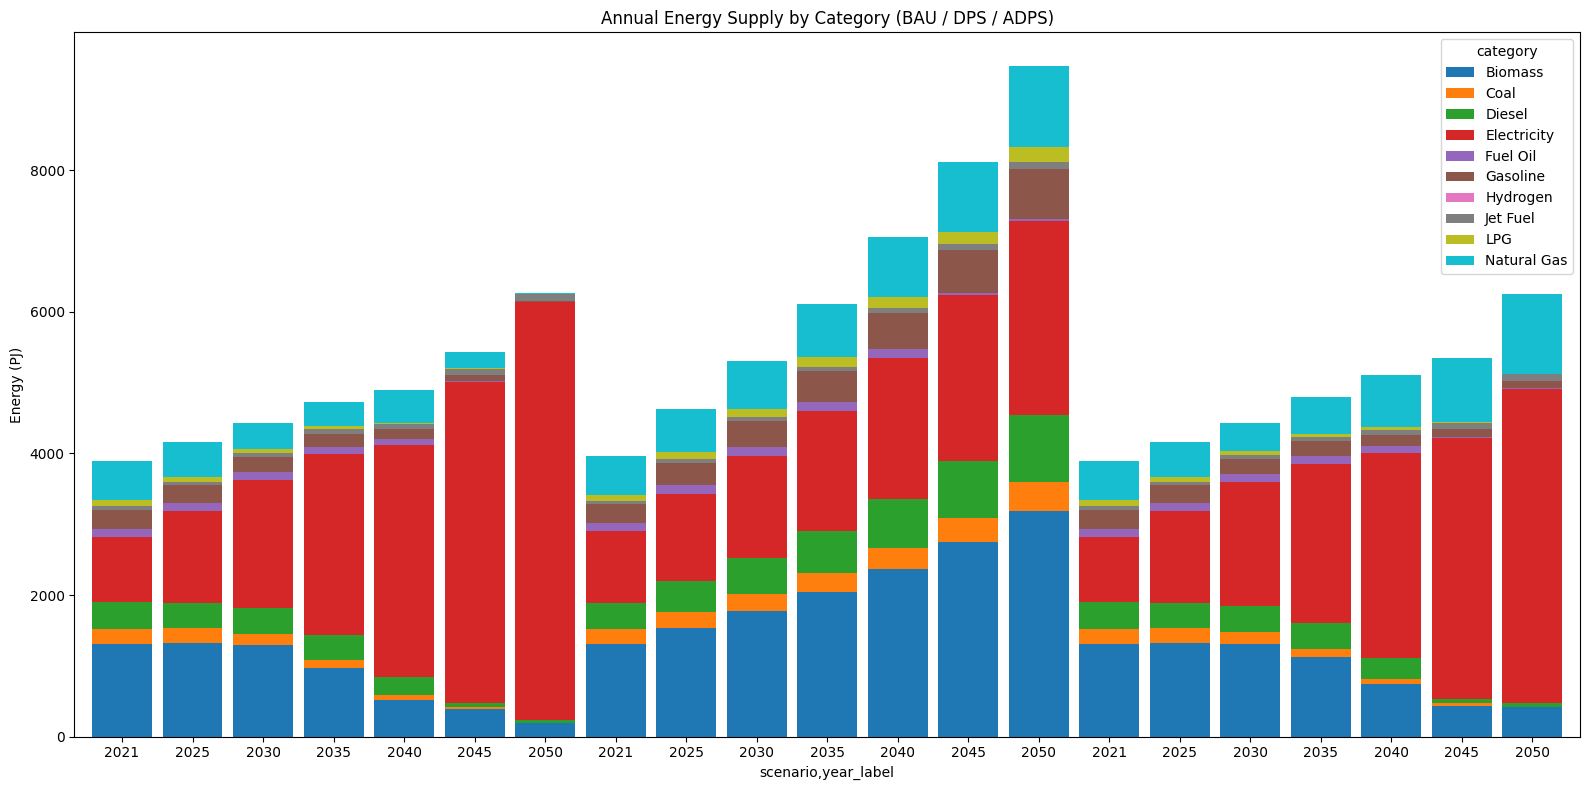

In [3]:
import yaml
import re
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------
# 1. Fuel → Category mapping
# ------------------------------------------
FUEL_TO_CATEGORY = {
    "BAG": "Biomass", "SGC": "Biomass", "OPL": "Biomass", "WOO": "Biomass",
    "AFR": "Biomass", "MSW": "Biomass",
    "BET": "Biomass", "BID": "Biomass",
    "BBG001": "Biomass", "BBG002": "Biomass",
    "BBD001": "Biomass", "BBD002": "Biomass",

    "COA001": "Coal", "COA002": "Coal",

    "NGS001": "Natural Gas", "NGS002": "Natural Gas", "DEMOTHNGS": "Natural Gas",

    "ELC001": "Electricity", "ELC002": "Electricity", "ELC003": "Electricity",
    "ELC004": "Electricity", "DEMINDELC": "Electricity", "DEMOTHELC": "Electricity",

    "DSL": "Diesel", "DEMOTHDSL": "Diesel",

    "GSL": "Gasoline", "DEMOTHGAS": "Gasoline",

    "LPG001": "LPG", "LPG002": "LPG", "DEMOTHLPG": "LPG",

    "JET": "Jet Fuel",

    "FOL": "Fuel Oil", "DEMOTHFOL": "Fuel Oil",

    "HDG001": "Hydrogen", "HDG002": "Hydrogen",
    "HDG003": "Hydrogen", "HDG004": "Hydrogen",
}


# ------------------------------------------
# 2. Load ProductionAnnual entries
# ------------------------------------------
def load_production(path):
    with open(path, "r") as f:
        raw = yaml.safe_load(f)

    sol = raw["Solution"][-1]["Variable"]

    pattern = re.compile(r"ProductionAnnual\[(.*)\]")
    rows = []

    for key, item in sol.items():
        m = pattern.search(key)
        if not m:
            continue

        region, fuel, year = m.group(1).split(",")
        rows.append({
            "year": int(year),
            "fuel": fuel.strip(),
            "value": float(item["Value"])
        })

    return pd.DataFrame(rows)


# ------------------------------------------
# 3. Map fuel → category, aggregate
# ------------------------------------------
def to_categories(df):
    df["category"] = df["fuel"].map(FUEL_TO_CATEGORY)
    return df.groupby(["year", "category"])["value"].sum().reset_index()


# ------------------------------------------
# 4. Plot all 3 scenarios EXACTLY like paper
# ------------------------------------------
def plot_three(BAU, DPS, ADPS):
    fig, ax = plt.subplots(figsize=(16,8))

    BAU["scenario"] = "BAU"
    DPS["scenario"] = "DPS"
    ADPS["scenario"] = "ADPS"

    full = pd.concat([BAU, DPS, ADPS])
    full["year_label"] = full["year"].astype(str)

    # ---- Keep ONLY selected years ----
    allowed_years = {2021, 2025, 2030, 2035, 2040, 2045, 2050}
    full = full[ full["year"].isin(allowed_years) ]

    pivot = full.pivot_table(
        index=["scenario", "year_label"],
        columns="category",
        values="value",
        fill_value=0
    )

    pivot.plot(kind="bar", stacked=True, ax=ax, width=0.85)

    plt.ylabel("Energy (PJ)")
    plt.title("Annual Energy Supply by Category (BAU / DPS / ADPS)")

    # ---- Show year labels for these years only ----
    xticks = list(range(len(pivot.index)))
    xticklabels = [idx[1] for idx in pivot.index]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=0)

    plt.tight_layout()
    plt.show()


# ------------------------------------------
# 5. RUN FOR ALL SCENARIOS
# ------------------------------------------
BAU_raw = load_production("results_BAU.yml")
DPS_raw = load_production("results_DPS.yml")
ADPS_raw = load_production("results_ADPS.yml")

BAU = to_categories(BAU_raw)
DPS = to_categories(DPS_raw)
ADPS = to_categories(ADPS_raw)

plot_three(BAU, DPS, ADPS)


In [ ]:
TECH_TO_CAT = {
    # Coal
    "PWRCOA": "Coal",
    "PWRCOACCS": "Coal",

    # Natural gas
    "PWRNGS": "Natural gas",
    "PWRNGSCCS": "Natural gas",

    # Biomass
    "PWRWOO": "Biomass",
    "PWRAFR": "Biomass",
    "PWRWOOCCS": "Biomass+CCS",
    "PWRAFRCCS": "Biomass+CCS",

    # Hydro
    "PWRDAM": "Hydro",
    "PWRROR": "Hydro",

    # Geothermal
    "PWRGEO": "Geothermal",

    # Nuclear
    "PWRNUC": "Nuclear",

    # Solar
    "PWRSOL": "Solar",

    # Solar + Battery
    "PWRSOLBAT": "Solar+Battery",

    # CSP
    "PWRCSP": "CSP",

    # Wind
    "PWRONW": "Onshore wind",
    "PWROFW": "Offshore wind",
}


COLOR_MAP = {
    "Coal": "#000000",
    "Natural gas": "#B3B3B3",
    "Biomass": "#2ca02c",
    "Biomass+CCS": "#b6d7a8",
    "Hydro": "#1f77b4",
    "Solar": "#ffcc00",
    "Solar+Battery": "#e6b800",
    "CSP": "#a0522d",
    "Onshore wind": "#003f87",
    "Offshore wind": "#6a0dad",
    "Nuclear": "#d62728",
    "Geothermal": "#8c564b",
}


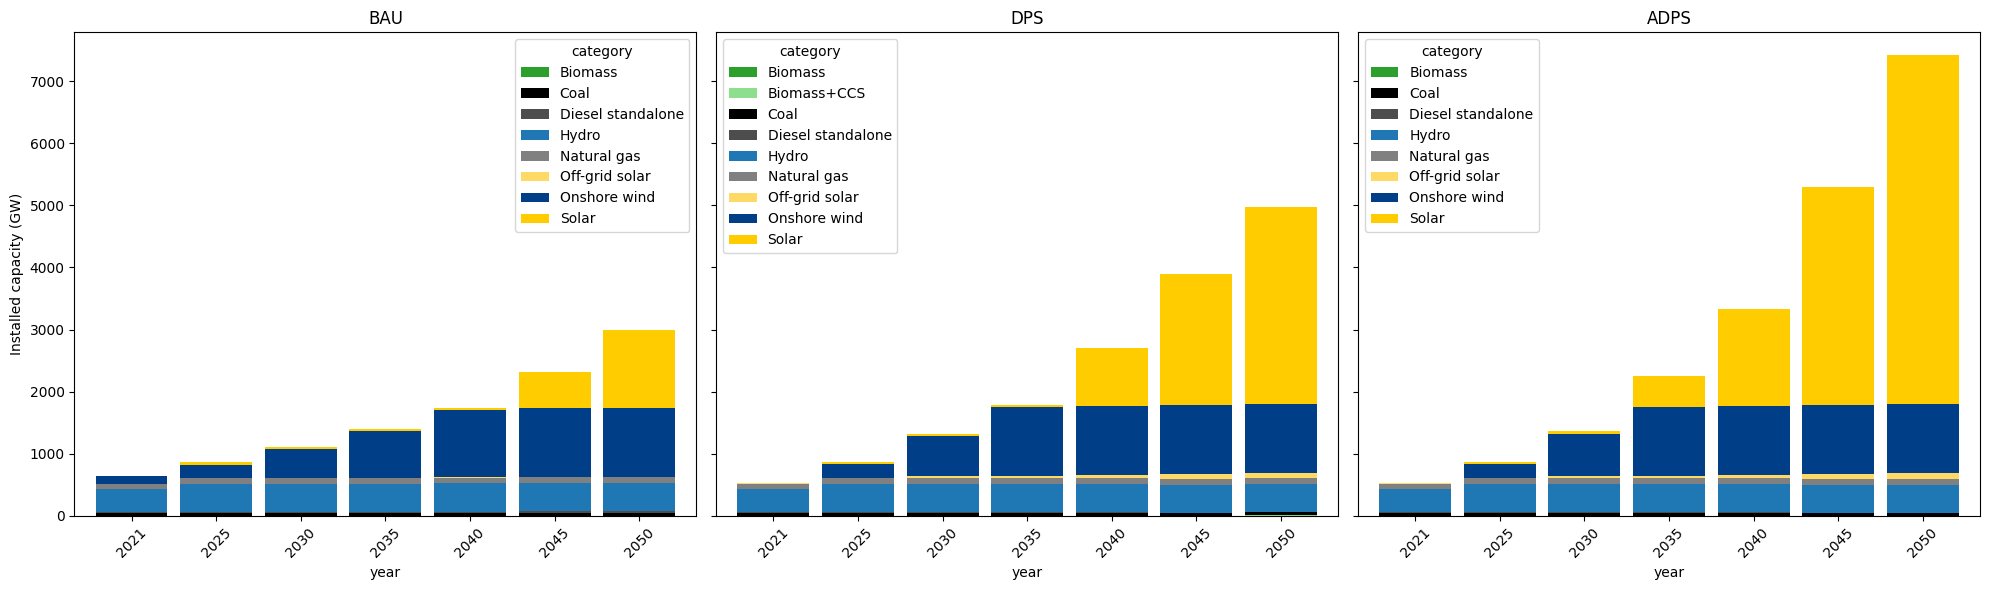

In [15]:
import yaml, re
import pandas as pd
import matplotlib.pyplot as plt

def load_capacity(path):
    with open(path, "r") as f:
        raw = yaml.safe_load(f)

    # BEEM sometimes puts variables under Solution[1] or Solution[-1]
    sol = raw["Solution"]
    var_dict = sol[-1].get("Variable", sol[1].get("Variable"))

    pattern = re.compile(r"TotalCapacityAnnual\[(.*)\]")
    rows = []

    for key, item in var_dict.items():
        m = pattern.match(key)
        if not m:
            continue

        region, tech, year = m.group(1).split(",")
        rows.append({
            "tech": tech.strip(),
            "year": int(year),
            "value": float(item["Value"])
        })

    return pd.DataFrame(rows)

def to_categories(df):
    df["category"] = df["tech"].map(TECH_TO_CAT)

    # drop all unassigned rows
    df = df[df["category"].notna()]

    df = df.groupby(["year", "category"])["value"].sum().reset_index()
    return df


def compare_three(BAU, DPS, ADPS):
    pivot_BAU = BAU.pivot(index="year", columns="category", values="value").fillna(0)
    pivot_DPS = DPS.pivot(index="year", columns="category", values="value").fillna(0)
    pivot_ADPS = ADPS.pivot(index="year", columns="category", values="value").fillna(0)

    allowed = [2021, 2025, 2030, 2035, 2040, 2045, 2050]
    pivot_BAU = pivot_BAU.loc[allowed]
    pivot_DPS = pivot_DPS.loc[allowed]
    pivot_ADPS = pivot_ADPS.loc[allowed]

    fig, axes = plt.subplots(1, 3, figsize=(20,6), sharey=True)

    for ax, pivot, title in zip(
        axes,
        [pivot_BAU, pivot_DPS, pivot_ADPS],
        ["BAU", "DPS", "ADPS"]
    ):
        pivot.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            width=0.85,
            color=[COLOR_MAP[c] for c in pivot.columns]  # SAME COLORS ALWAYS
        )
        ax.set_title(title)
        ax.set_xticklabels(pivot.index, rotation=45)

    axes[0].set_ylabel("Installed capacity (GW)")
    plt.tight_layout()
    plt.show()



BAU_raw = load_capacity("results_BAU.yml")
DPS_raw = load_capacity("results_DPS.yml")
ADPS_raw = load_capacity("results_ADPS.yml")

BAU = to_categories(BAU_raw)
DPS = to_categories(DPS_raw)
ADPS = to_categories(ADPS_raw)

compare_three(BAU, DPS, ADPS)




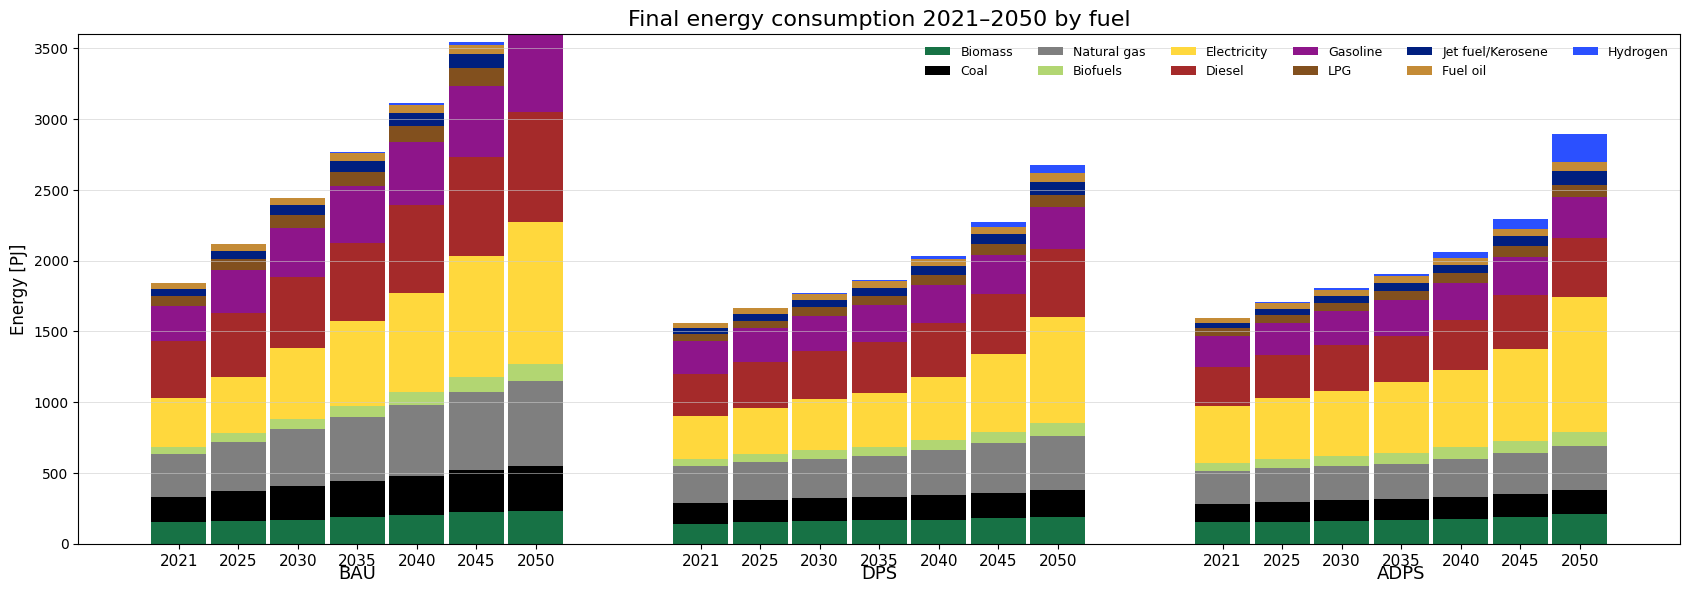

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# ===========================
#  YEARS + SCENARIOS
# ===========================
years = ["2021", "2025", "2030", "2035", "2040", "2045", "2050"]
scenarios = ["BAU", "DPS", "ADPS"]

# ===========================
#  COLORS (EXACT FROM IMAGE)
# ===========================
colors = {
    "Biomass":          "#177245",
    "Coal":             "#000000",
    "Natural gas":      "#7f7f7f",
    "Biofuels":         "#b2d672",
    "Electricity":      "#ffd83d",
    "Diesel":           "#a52a2a",
    "Gasoline":         "#8e158a",
    "LPG":              "#82501e",
    "Jet fuel/Kerosene":"#001f7f",
    "Fuel oil":         "#c48b36",
    "Hydrogen":         "#2b50ff"
}

fuel_order = list(colors.keys())

# ===========================
#  APPROX VALUES (VISUALLY READ)
# ===========================
# BAU (left block)
BAU = {
    "Biomass":     [150,160,170,185,200,220,230],
    "Coal":        [180,210,240,260,280,300,320],
    "Natural gas": [300,350,400,450,500,550,600],
    "Biofuels":    [50,60,70,80,90,110,120],
    "Electricity": [350,400,500,600,700,850,1000],
    "Diesel":      [400,450,500,550,620,700,780],
    "Gasoline":    [250,300,350,400,450,500,550],
    "LPG":         [70,80,90,100,110,130,150],
    "Jet fuel/Kerosene":[50,60,70,80,90,100,110],
    "Fuel oil":    [40,45,50,55,60,65,70],
    "Hydrogen":    [0,0,0,5,10,20,40]
}

# DPS (middle block)
DPS = {
    "Biomass":     [140,150,160,165,170,180,190],
    "Coal":        [150,155,160,165,170,180,190],
    "Natural gas": [260,270,280,290,320,350,380],
    "Biofuels":    [50,55,60,65,70,80,90],
    "Electricity": [300,330,360,380,450,550,750],
    "Diesel":      [300,320,340,360,380,420,480],
    "Gasoline":    [230,240,250,260,270,280,300],
    "LPG":         [50,55,60,65,70,75,85],
    "Jet fuel/Kerosene":[40,45,50,55,60,70,90],
    "Fuel oil":    [40,42,45,48,50,55,60],
    "Hydrogen":    [0,0,5,10,20,30,60]
}

# ADPS (right block)
ADPS = {
    "Biomass":     [150,155,160,165,175,190,210],
    "Coal":        [130,140,145,150,155,160,170],
    "Natural gas": [230,240,245,250,270,290,310],
    "Biofuels":    [60,65,70,75,80,85,100],
    "Electricity": [400,430,460,500,550,650,950],
    "Diesel":      [280,300,320,330,350,380,420],
    "Gasoline":    [220,230,240,250,260,270,290],
    "LPG":         [50,55,60,65,70,75,85],
    "Jet fuel/Kerosene":[40,45,50,55,60,70,100],
    "Fuel oil":    [35,40,45,48,50,55,60],
    "Hydrogen":    [0,5,10,20,40,70,200]
}

scenario_data = [BAU, DPS, ADPS]

# ===========================
#  PLOTTING LAYOUT MATCH
# ===========================

plt.figure(figsize=(17,6))

# Spacing exactly like the original:
# 7 bars per scenario, with big gaps between blocks
block_gap = 1.8
bar_width = 0.6

x_positions = []
current = 0
for _ in scenarios:
    block = [current + i*(bar_width+0.05) for i in range(7)]
    x_positions.append(block)
    current = block[-1] + block_gap

# Draw stacked bars
for s, scenario in enumerate(scenario_data):
    for i, year in enumerate(years):
        bottom = 0
        xpos = x_positions[s][i]
        for fuel in fuel_order:
            val = scenario[fuel][i]
            plt.bar(xpos, val, bottom=bottom, color=colors[fuel], width=bar_width)
            bottom += val

# X-ticks exactly under bars
ticks = []
labels = []
for s in range(3):
    for i in range(7):
        ticks.append(x_positions[s][i])
        labels.append(years[i])

plt.xticks(ticks, labels, fontsize=11)

# Block labels under groups
for s, name in enumerate(scenarios):
    block_center = np.mean(x_positions[s])
    plt.text(block_center, -250, name, ha='center', fontsize=13)

plt.ylim(0, 3600)
plt.ylabel("Energy [PJ]", fontsize=12)

plt.title("Final energy consumption 2021–2050 by fuel", fontsize=16)

# Legend
plt.legend(fuel_order, ncol=6, fontsize=9, frameon=False)

plt.grid(axis='y', linewidth=0.4, color="#cccccc")
plt.tight_layout()
plt.show()


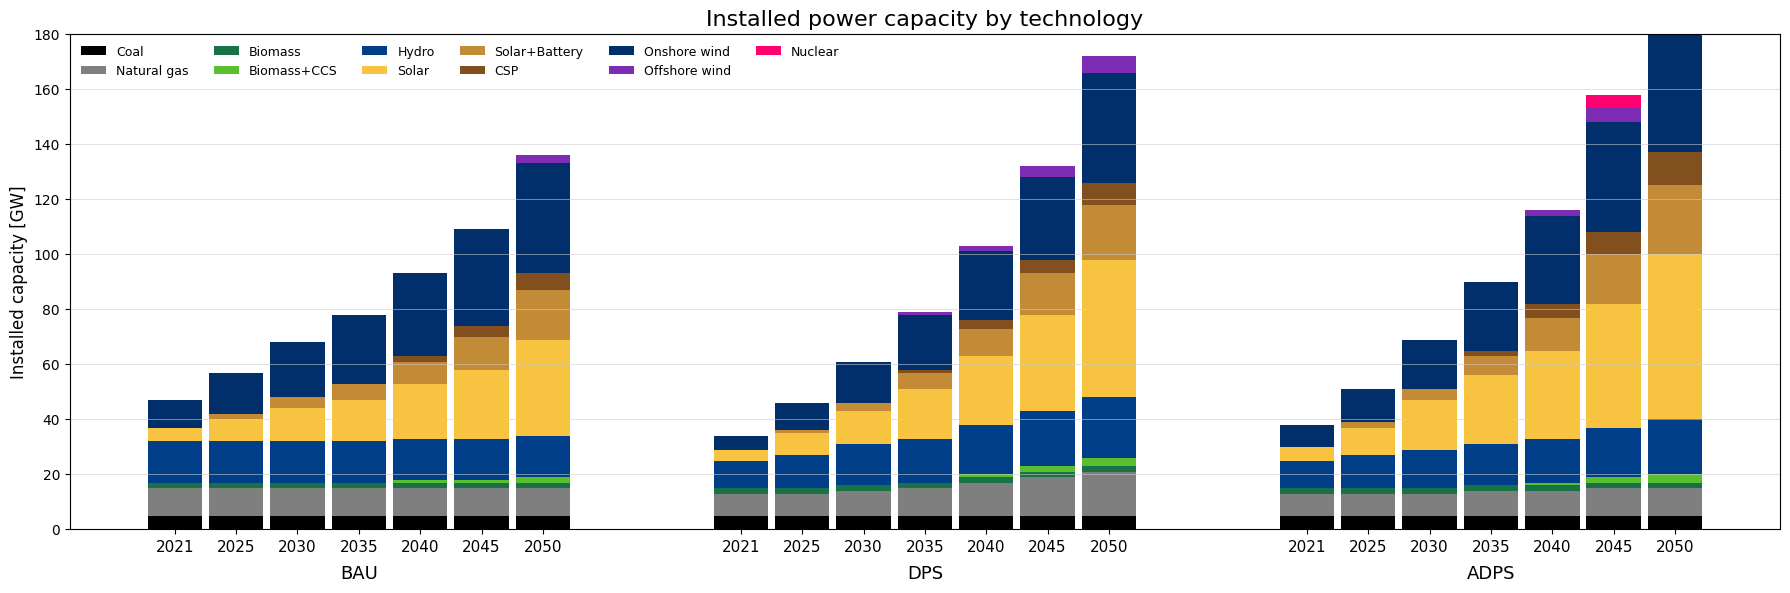

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# YEARS & SCENARIOS
# ==========================================
years = ["2021","2025","2030","2035","2040","2045","2050"]
scenarios = ["BAU","DPS","ADPS"]

# ==========================================
# COLORS (EXACT FROM IMAGE)
# ==========================================
colors = {
    "Coal":          "#000000",
    "Natural gas":   "#7f7f7f",
    "Biomass":       "#177245",
    "Biomass+CCS":   "#5abf2f",
    "Hydro":         "#003f87",
    "Solar":         "#f8c341",
    "Solar+Battery": "#c48b36",
    "CSP":           "#82501e",
    "Onshore wind":  "#002f6c",
    "Offshore wind": "#7d2db3",
    "Nuclear":       "#ff006e"
}

fuel_order = list(colors.keys())

# ==========================================
# APPROXIMATED VALUES (VISUALLY READ)
# ==========================================

# BAU block
BAU = {
    "Coal":          [5,5,5,5,5,5,5],
    "Natural gas":   [10,10,10,10,10,10,10],
    "Biomass":       [2,2,2,2,2,2,2],
    "Biomass+CCS":   [0,0,0,0,1,1,2],
    "Hydro":         [15,15,15,15,15,15,15],
    "Solar":         [5,8,12,15,20,25,35],
    "Solar+Battery": [0,2,4,6,8,12,18],
    "CSP":           [0,0,0,0,2,4,6],
    "Onshore wind":  [10,15,20,25,30,35,40],
    "Offshore wind": [0,0,0,0,0,0,3],
    "Nuclear":       [0,0,0,0,0,0,0]
}

# DPS block
DPS = {
    "Coal":          [5,5,5,5,5,5,5],
    "Natural gas":   [8,8,9,10,12,14,16],
    "Biomass":       [2,2,2,2,2,2,2],
    "Biomass+CCS":   [0,0,0,0,1,2,3],
    "Hydro":         [10,12,15,16,18,20,22],
    "Solar":         [4,8,12,18,25,35,50],
    "Solar+Battery": [0,1,3,6,10,15,20],
    "CSP":           [0,0,0,1,3,5,8],
    "Onshore wind":  [5,10,15,20,25,30,40],
    "Offshore wind": [0,0,0,1,2,4,6],
    "Nuclear":       [0,0,0,0,0,0,0]
}

# ADPS block
ADPS = {
    "Coal":          [5,5,5,5,5,5,5],
    "Natural gas":   [8,8,8,9,9,10,10],
    "Biomass":       [2,2,2,2,2,2,2],
    "Biomass+CCS":   [0,0,0,0,1,2,3],
    "Hydro":         [10,12,14,15,16,18,20],
    "Solar":         [5,10,18,25,32,45,60],
    "Solar+Battery": [0,2,4,7,12,18,25],
    "CSP":           [0,0,0,2,5,8,12],
    "Onshore wind":  [8,12,18,25,32,40,50],
    "Offshore wind": [0,0,0,0,2,5,10],
    "Nuclear":       [0,0,0,0,0,5,8]
}

scenario_data = [BAU, DPS, ADPS]

# ==========================================
# LAYOUT — EXACT MATCH OF SPACING
# ==========================================
plt.figure(figsize=(18,6))

block_gap = 2.0
bar_width = 0.55

x_positions = []
cur = 0

for _ in scenarios:
    block = [cur + i*(bar_width+0.07) for i in range(7)]
    x_positions.append(block)
    cur = block[-1] + block_gap

# ==========================================
# STACKED BAR DRAWING
# ==========================================
for s, sc_data in enumerate(scenario_data):
    for i, year in enumerate(years):
        bottom = 0
        xpos = x_positions[s][i]
        for fuel in fuel_order:
            val = sc_data[fuel][i]
            plt.bar(xpos, val, bottom=bottom, width=bar_width, color=colors[fuel])
            bottom += val

# ==========================================
# AXIS LABELS + BLOCK LABELS
# ==========================================
ticks = []
labels = []
for s in range(3):
    for i in range(7):
        ticks.append(x_positions[s][i])
        labels.append(years[i])

plt.xticks(ticks, labels, fontsize=11)

for s, name in enumerate(scenarios):
    center = np.mean(x_positions[s])
    plt.text(center, -18, name, ha='center', fontsize=13)

plt.ylabel("Installed capacity [GW]", fontsize=12)
plt.ylim(0,180)
plt.grid(axis='y', color="#cccccc", linewidth=0.4)

plt.title("Installed power capacity by technology", fontsize=16)

plt.legend(fuel_order, ncol=6, fontsize=9, frameon=False)

plt.tight_layout()
plt.show()
